# XB Model set-up Notebook
<img style="float:right;" src="https://irr2.gmu.edu/inc/AIETemplate/MasonM.png" width=150px>

### XB input
#### - Steps to follow:
  1. Download the [Octave executable](https://ftp.gnu.org/gnu/octave/windows/octave-4.4.0-w64_1-installer.exe)
  2. Download the [XBeach matlab toolbox](https://oss.deltares.nl/documents/48999/58264/xbeach_release_10May2013.zip/366a38c9-1e30-4792-82ba-0bd5804c1ce2?version=1.0&download=true)
  3. Download the XBeach model libraries
  4. Import Libraries & Assign Paths
  5. Assign Tasks
  6. Save Report

### Directions to installing the Octave executable
1. Download and run the Octave executable
2. Then after go to the control panel -> system and security -> system -> advanced -> environment variables
3. Find the path variable and edit it and add the path to the Octave bin directory
4. Open anaconda and install oct2py

### XBeach Matlab toolbox
1. Open oetsettings.m and comment out the NETCDF section at the end of it
2. Open the xb_write_params on line 89 add the directory for the xbeach model library

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from oceanwaves import OceanWaves
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot,iplot, init_notebook_mode
import oct2py
from oct2py import octave
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

### Run oetsettings.m to initialize toolbox

In [2]:
octave.addpath(r'P:\Temp\tmiesse\xb\xbeach_release_10May2013');
octave.addpathfast(r'P:\Temp\tmiesse\xb\xbeach_release_10May2013');
octave.run('oetsettings.m');
clear_output()

### Import Cross section

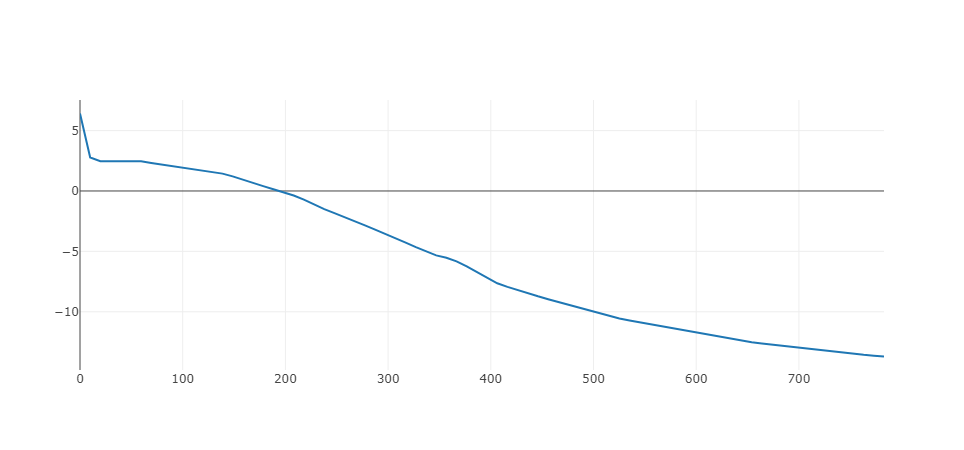

In [3]:
root = r'C:\Users\tmiesse\Work\adcirc_prod\data\xb_data'
cross= 'cross_v1.csv'
grid = pd.read_csv(os.path.join(root,cross))
x = grid['X'][:]
z = grid['Graphic Profile 1'][:]
trace = go.Scatter(
    x = x,
    y = z)
data = [trace]
iplot(data)

### Optimize Cross section

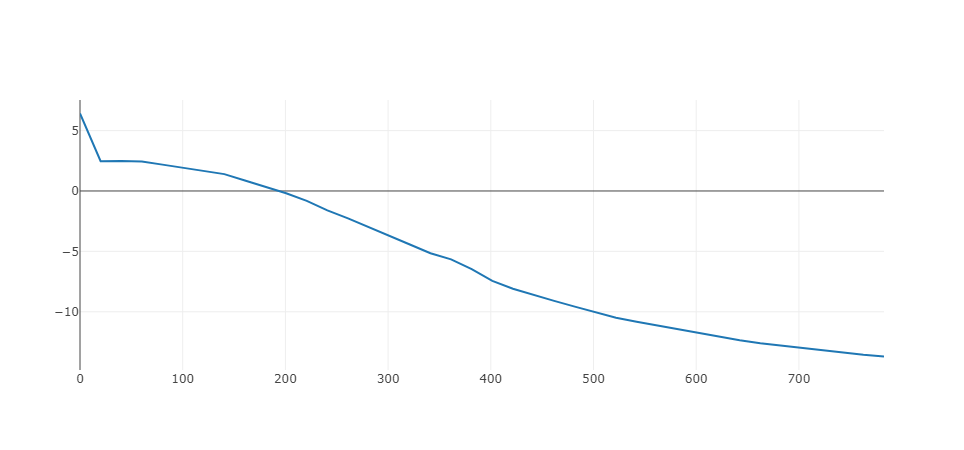

In [4]:
dxmin = 2.0
xgr = np.linspace(x.iloc[0],x.iloc[-1],int(len(x))/dxmin)
zgr = np.interp(xgr,x,z)
octave.addpath(r'P:\Temp\tmiesse\xb\xbeach_release_10May2013\applications\xbeach\xb_modelsetup\xb_grid');
bathy = octave.xb_generate_bathy('x',xgr,'z',zgr)
trace = go.Scatter(
    x = xgr,
    y = zgr)
data = [trace]
iplot(data)

In [5]:
def find_columns(data):
    data2 = []
    for f in data.split(' '):
        if f != '':
            data2.append(f)   
    return data2

In [6]:
raw_tide = pd.read_csv(os.path.join(root,'WLFort63.txt'),sep=' ')

In [ ]:
raw_tide

In [8]:
tide,tide2 = [],[]
ttime= []
ii=0
with open(os.path.join(root,'WLFort63.txt'),'r') as fout:
    lines = fout.readlines()
    for i in range(3,len(lines),2):
        ii+=1
        ttime.append(3600*ii)
        tide.append(lines[i].strip())
    for i3 in range(0,len(tide)):
        tide2.append(find_columns(tide[i3][6:].split('E')[0]))

In [ ]:
octave.addpath(r'P:\Temp\tmiesse\xb\xbeach_release_10May2013\applications\xbeach\xb_modelsetup\xb_bc');
tide = octave.xb_generate_tide('time',ttime,'front',tide2)

### Generate Wave Settings

In [10]:
octave.addpath(r'P:\Temp\tmiesse\xb\xbeach_release_10May2013\applications\xbeach\xb_modelsetup\xb_bc');
wave = octave.xb_generate_waves('Hm0',0.75,'Tp',4,'mainang',90,'gammajsp',3.3,'s',10,'fnyq',0.45)

### Generate Model Settings

In [11]:
xb_set=octave.xb_generate_settings('outputformat','Fortran', 
        'thetamin',0.0,'thetamax',180.0,'dtheta',180.0,'dtheta_s',5.0,'xori',0.0,
        'instat','jons','morfac', 1.0,'posdwn',-1.0,'avalanching',0.0,
        'morstart', 0.0,'CFL', 0.7,'front', 'abs_1d','random',0,'taper',10.0,
        'back', 'abs_1d','left','neumann','right','neumann','mpiboundary','auto','morfacopt',0,
        'thetanaut', 1.0,'zs0',0.0,'single_dir',0.0,'tstop', 129600.0,'tstart', 0.0,
        'tint', 259200.0,'tintm',1200.0,'tintg',259200.0,'epsi',-1.0,'facua',0.30,'bedfriction', 'manning',
        'meanvar',{'zb', 'zs', 'H','u','v'} ,'globalvar',{'zb', 'zs','H','u','v'});

### Join the generated Settings

In [12]:
octave.addpath(r'P:\Temp\tmiesse\xb\xbeach_release_10May2013\general\xstruct_fun');
join = octave.xs_join(bathy,wave,xb_set)

### Generate the input files

In [13]:
octave.addpath(r'P:\Temp\tmiesse\xb\xbeach_release_10May2013\applications\xbeach\xb_io');
octave.xb_write_input(os.path.join(r'P:\Temp\tmiesse\xb\test','params.txt'),join)

start
Here
add general
